In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/california-housing-prices/housing.csv


In [2]:
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
# Chargement des données
df = pd.read_csv("/kaggle/input/california-housing-prices/housing.csv")

In [4]:
housing_with_id = df.reset_index() # adds an `index` column
#Train-set and Test-set
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

<Axes: >

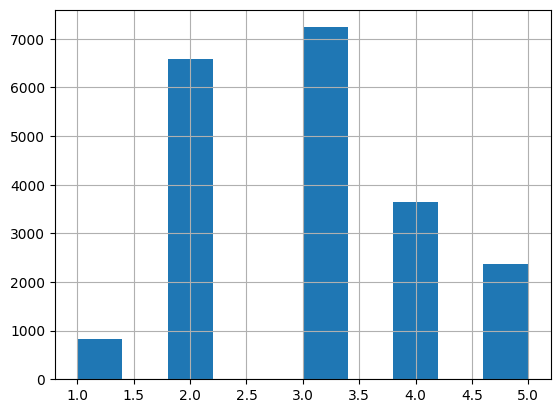

In [5]:
#Faire le stratified sampling
df["income_cat"] = pd.cut(df["median_income"],
bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
labels=[1, 2, 3, 4, 5])
df["income_cat"].hist()


In [6]:
#Une division representative de l'ensemble du dataset
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [7]:
#Retour au dataset normal
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [8]:
#Labels and datas
housing = strat_train_set.drop("median_house_value", axis=1) 
housing_labels = strat_train_set["median_house_value"].copy() 
if isinstance(housing, np.ndarray):
    print("data est un numpy array.")
else:
    print("data n'est pas un numpy array.")

data n'est pas un numpy array.


In [9]:
#Install the requiered estimators
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OrdinalEncoder
#Processing to One-hot encoding
from sklearn.preprocessing import OneHotEncoder
#Feature scaling
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score

In [10]:
#CUstom transformers
#un transformers qui combine les attributs
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
        bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
#Convertion de housing en np.array
housingNp=housing.to_numpy()
housing_extra_attribs = attr_adder.transform(housingNp)

In [11]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [12]:
#Entrainer avec des echantillons
housing_sample = housing.sample(500, random_state=42)
labels_sample = housing_labels.loc[housing_sample.index]
if isinstance(housing_sample, pd.DataFrame):
    print("data est un DataFrame.")
else:
    print("data n'est pas un numpy array.")

housing_sample.iloc[:2]

data est un DataFrame.


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
2924,-119.01,35.37,38.0,1702.0,380.0,1191.0,366.0,1.8801,INLAND
11713,-120.15,39.15,25.0,1669.0,348.0,163.0,78.0,5.7500,INLAND


In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import joblib

In [14]:
#Complete function to train the model
def model_trainer_SVR(data,labels):
    
    #Drop categorical attribute
    num_data = data.drop("ocean_proximity", axis=1)
   
    #Handling categorical attributes
    cat_attribs = data[["ocean_proximity"]]
    

    #Numeric pipeline

    num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder',CombinedAttributesAdder(add_bedrooms_per_room=False)),
    ('std_scaler', StandardScaler()),
    ])

    cat_pipeline = Pipeline([
        ('encoder', OneHotEncoder())
    ])

    

    # ColumnTransformer pour combiner les deux pipelines
    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_data.columns),
        ("cat", cat_pipeline, ['ocean_proximity'])
    ])
    

    svr_pipeline = Pipeline([
        ('preparation', full_pipeline), 
        ('svr', SVR(kernel='rbf'))       
    ])

        # Grille d’hyperparamètres pour RBF
    param_grid = {
        'svr__C': [10,100, 1000,10000],             # Plus C est grand, plus le modèle est flexible
        'svr__epsilon': [0.01,0.1, 0.5,1],      # Plus epsilon est petit, plus le modèle est précis
        'svr__gamma': [0.01,0.1,0.2,1]           # gamma petit = modèle plus lisse
    }
    
    # GridSearch avec validation croisée
    grid_search = GridSearchCV(
        svr_pipeline,
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error',  # car on veut minimiser l'erreur
        verbose=2,                         # pour suivre la progression
        n_jobs=-1                          # utiliser tous les cœurs du CPU
    )
    grid_search.fit(data, labels)
    
    # Sauvegarde uniquement du meilleur modèle entraîné
    joblib.dump(grid_search.best_estimator_, "model_SVR.pkl")
    
    # Résultats
    print("Meilleurs hyperparamètres trouvés :")
    print(grid_search.best_params_)
    
    print("Meilleur RMSE :")
    print(np.sqrt(-grid_search.best_score_))
    
    # Retourne juste le pipeline final entraîné
    return grid_search.best_estimator_

    
    
        
       

In [15]:
final_model_SVR = model_trainer_SVR(housing_sample,labels_sample)
final_model_SVR

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Meilleurs hyperparamètres trouvés :
{'svr__C': 10000, 'svr__epsilon': 0.01, 'svr__gamma': 0.1}
Meilleur RMSE :
85888.49622623913


Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder(add_bedrooms_per_room=False)),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['ocean_proximity'])])),
                ('svr', SVR(C=10000, epsilon=0.01, gamma=0.1))])

In [16]:
#Complete function to train the model
def model_trainer_RandomForestRegressor(data,labels):
    #Drop categorical attribute
    num_data = data.drop("ocean_proximity", axis=1)
   
    #Handling categorical attributes
    cat_attribs = data[["ocean_proximity"]]
    

    #Numeric pipeline

    num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder',CombinedAttributesAdder(add_bedrooms_per_room=False)),
    ('std_scaler', StandardScaler()),
    ])

    cat_pipeline = Pipeline([
        ('encoder', OneHotEncoder())
    ])

    

    # ColumnTransformer pour combiner les deux pipelines
    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_data.columns),
        ("cat", cat_pipeline, ['ocean_proximity'])
    ])
    
  
    
    rfr_pipeline = Pipeline([
    ('preparation', full_pipeline), 
    ('RFR', RandomForestRegressor())       
    ])

    
    # Grille des hyperparamètres avec les préfixes appropriés pour RandomForestRegressor
    param_grid = [
        {'RFR__n_estimators': [3, 10, 30], 'RFR__max_features': [2, 4, 6, 8]},
        {'RFR__bootstrap': [False], 'RFR__n_estimators': [3, 10], 'RFR__max_features': [2, 3, 4]},
    ]
    
    grid_search = GridSearchCV(rfr_pipeline, param_grid, cv=5,
                              scoring='neg_mean_squared_error', return_train_score=True)
    grid_search.fit(data, labels)
    joblib.dump(grid_search.best_estimator_, "model_RFR.pkl")

    
   
    # Résultats
    print("Meilleurs hyperparamètres trouvés :")
    print(grid_search.best_params_)
    
    print("Meilleur RMSE :")
    print(np.sqrt(-grid_search.best_score_))
    return grid_search.best_estimator_
    
        
       

In [17]:
final_model_RFR=model_trainer_RandomForestRegressor(housing_sample,labels_sample)
final_model_RFR

Meilleurs hyperparamètres trouvés :
{'RFR__max_features': 8, 'RFR__n_estimators': 30}
Meilleur RMSE :
63587.0323136061


Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder(add_bedrooms_per_room=False)),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['ocean_proximity'])])),
                ('RFR',
                 RandomForestRegressor(max_features=8, n_estimators=30))])

In [18]:
def model_trainer_LinearRegression(data,labels):
     #Drop categorical attribute
    num_data = data.drop("ocean_proximity", axis=1)
   
    #Handling categorical attributes
    cat_attribs = data[["ocean_proximity"]]
    

    #Numeric pipeline

    num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder',CombinedAttributesAdder(add_bedrooms_per_room=False)),
    ('std_scaler', StandardScaler()),
    ])

    cat_pipeline = Pipeline([
        ('encoder', OneHotEncoder())
    ])

    
    # ColumnTransformer pour combiner les deux pipelines
    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_data.columns),
        ("cat", cat_pipeline, ['ocean_proximity'])
    ])
    
    lr_pipeline = Pipeline([
    ('preparation', full_pipeline), 
    ('LR', LinearRegression())       
    ])

    
    #Making Cross-Validation
    #10 entraînements complets du modèle sont réalisés. Avec un modèle lourd comme ton SVM polynomial, ça devient rapidement très lent.
    scores = cross_val_score(lr_pipeline, data, labels,
                scoring="neg_mean_squared_error", cv=10)
    lr_rmse_scores = np.sqrt(-scores)
    # 2. Fit le pipeline sur **toutes** les données (en entier)
    lr_pipeline.fit(data, labels)
    
    joblib.dump(lr_pipeline, "model_LR.pkl")

    
    #Displaying scores
    display_scores(lr_rmse_scores)

    return lr_pipeline
    

In [19]:
final_model_LR = model_trainer_LinearRegression(housing_sample,labels_sample)

Scores: [61604.1088332  70919.44565253 79016.14041198 70509.77190792
 84901.271965   58970.35995342 62171.56031672 67904.75683103
 74906.86619503 55375.56981986]
Mean: 68627.9851886692
Standard deviation: 8839.62357336544


In [20]:
def model_trainer_DecissionTreeRegressor(data,labels):
     #Drop categorical attribute
    num_data = data.drop("ocean_proximity", axis=1)
   
    #Handling categorical attributes
    cat_attribs = data[["ocean_proximity"]]
    

    #Numeric pipeline

    num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder',CombinedAttributesAdder(add_bedrooms_per_room=False)),
    ('std_scaler', StandardScaler()),
    ])

    cat_pipeline = Pipeline([
        ('encoder', OneHotEncoder())
    ])

    
    # ColumnTransformer pour combiner les deux pipelines
    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_data.columns),
        ("cat", cat_pipeline, ['ocean_proximity'])
    ])
    
    dtr_pipeline = Pipeline([
    ('preparation', full_pipeline), 
    ('DTR', DecisionTreeRegressor())       
    ])

    
   

    param_distribs = {
        'DTR__max_depth': [3, 5, 10, None],
        'DTR__min_samples_split': randint(2, 20),
        'DTR__min_samples_leaf': randint(1, 20),
        'DTR__max_features': ['sqrt', 'log2', None]
    }
    
    rnd_search = RandomizedSearchCV(dtr_pipeline, param_distribs,
                                    n_iter=30, cv=5,
                                    scoring='neg_mean_squared_error',
                                    random_state=42)
    rnd_search.fit(data, labels)  # ou directement un pipeline complet
    
    joblib.dump(rnd_search.best_estimator_, "model_TR.pkl")
    
    

    print("Meilleurs hyperparamètres :", rnd_search.best_params_)
    print("Meilleur RMSE :", np.sqrt(-rnd_search.best_score_))
    return rnd_search.best_estimator_


In [21]:
final_model_TR = model_trainer_DecissionTreeRegressor(housing_sample,labels_sample)

Meilleurs hyperparamètres : {'DTR__max_depth': 10, 'DTR__max_features': None, 'DTR__min_samples_leaf': 14, 'DTR__min_samples_split': 18}
Meilleur RMSE : 71993.04018078199


In [22]:
# Sauvegarde du modèle entraîné
joblib.dump(final_model_RFR, "model_RFR.pkl")
joblib.dump(final_model_SVR, "model_SVR.pkl")
joblib.dump(final_model_LR, "model_LR.pkl")
joblib.dump(final_model_TR, "model_TR.pkl")
print("Modèle sauvegardé sous model.pkl")


Modèle sauvegardé sous model.pkl


In [23]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.0 MB/s eta 0:00:00


In [24]:
import json

scores = {
    "RandomForest": 64080.65741243783,
    "SVR (Polynomial)": 85888.49622623913,
    "Linear Regression":  68627.9851886692,
    "Decision Tree": 72088.5889239283
}

with open("model_scores.json", "w") as f:
    json.dump(scores, f, indent=2)

print("Fichier model_scores.json créé avec succès.")


Fichier model_scores.json créé avec succès.


In [25]:
import gradio as gr
import matplotlib.pyplot as plt
import pandas as pd



# 🔁 Chargement des modèles sauvegardés
model_RFR = joblib.load("model_RFR.pkl")
model_SVR = joblib.load("model_SVR.pkl")
model_LR = joblib.load("model_LR.pkl")
model_TR = joblib.load("model_TR.pkl")

# 📊 Fonction pour prédire avec tous les modèles et afficher le meilleur
def predict_price(longitude, latitude, housing_median_age, total_rooms,
                  total_bedrooms, population, households, median_income,
                  ocean_proximity):

    # Création d'un DataFrame pandas avec les données d'entrée
    input_data = pd.DataFrame([[
        longitude, latitude, housing_median_age, total_rooms,
        total_bedrooms, population, households, median_income,
        ocean_proximity
    ]], columns=[
        "longitude", "latitude", "housing_median_age", "total_rooms",
        "total_bedrooms", "population", "households", "median_income", "ocean_proximity"
    ])

    # Prédictions avec chaque modèle (les modèles sont déjà formés avec le pipeline complet)
    models = {
        "RandomForest": model_RFR,
        "SVR (Polynomial)": model_SVR,
        "Linear Regression": model_LR,
        "Decision Tree": model_TR
    }
    results = {}
    for name, model in models.items():
        try:
            # Prédiction avec chaque modèle (le prétraitement est déjà intégré dans les pipelines des modèles)
            pred = model.predict(input_data)[0]
            results[name] = pred
        except Exception as e:
            results[name] = f"Erreur: {e}"

    # 🎯 Meilleur modèle (valeur prédictive la plus basse ici comme exemple)
    best_model = min(results, key=lambda k: results[k] if isinstance(results[k], float) else float('inf'))
    best_predict = model_RFR.predict(input_data)[0]
    

    # Charger les scores RMSE manuellement définis
    with open("model_scores.json") as f:
        saved_scores = json.load(f)
    
    # 🎯 Meilleur modèle (le plus petit RMSE)
    best_model = min(saved_scores, key=saved_scores.get)
    
    # 📈 Graphe basé sur les scores
    fig, ax = plt.subplots()
    ax.bar(saved_scores.keys(), saved_scores.values(), color='skyblue')
    ax.set_ylabel("RMSE")
    ax.set_title("Comparaison des modèles (RMSE)")
    plt.xticks(rotation=10)
    
    # 🏆 Texte
    best_rmse = saved_scores[best_model]
    rmse_text = f"💰 RMSE : {best_rmse:,.2f}"
    
    return f"🏆 Meilleur modèle : {best_model}\n{rmse_text}\n Meilleur prediction :{best_predict}", fig


# 🎛️ Inputs avec valeurs pré-remplies
inputs = [gr.Number(label="Longitude", value=-122.23),
    gr.Number(label="Latitude", value=37.88),
    gr.Number(label="Housing Median Age", value=41),
    gr.Number(label="Total Rooms", value=880),
    gr.Number(label="Total Bedrooms", value=129),
    gr.Number(label="Population", value=322),
    gr.Number(label="Households", value=126),
    gr.Number(label="Median Income", value=8.3252),
    gr.Dropdown(["INLAND", "<1H OCEAN", "NEAR BAY", "NEAR OCEAN", "ISLAND"], label="Ocean Proximity", value="NEAR BAY")
]

# 🧪 Interface Gradio
demo = gr.Interface(
    fn=predict_price,
    inputs=inputs,
    outputs=["text", "plot"],
    title="🏠 Prédiction du prix d'une maison en Californie",
    description="Entrez les caractéristiques d'une maison pour estimer son prix avec différents modèles de ML."
)

if __name__ == "__main__":
    demo.launch()


* Running on local URL:  http://127.0.0.1:7860
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://53f6ecee82243ef312.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [26]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3
